In [5]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
words = stopwords.words("english")
stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brucedecker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brucedecker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
stopwords_set = set(stopwords.words("english"))
df = pd.read_csv('1429_1.csv', keep_default_na=False, skip_blank_lines=False)
df = df.replace(np.nan, '', regex=True)



In [7]:
df['newComments'] = df[['reviews.text', 'reviews.title']].apply(lambda x: ' '.join(x), axis=1)
df['newComments'] = df['reviews.text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in stopwords_set]).lower())
TVec = TfidfVectorizer(sublinear_tf=True, min_df=6, stop_words='english')
ch2 = SelectPercentile(chi2, percentile=9.5)
X_text_processing = TVec.fit_transform(df['newComments'])

#df['reviews.rating'].astype(str).astype(int).astype(float)
#df['reviews.rating'].convert_objects(convert_numeric=True)
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'],errors='coerce')

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df[['reviews.rating']])
df['reviews.rating']=imp.transform(df[['reviews.rating']]).ravel()
'''
imputed_DF = pd.DataFrame(imp.fit_transform(df.loc[:, 14]))
imputed_DF.columns = df.columns
imputed_DF.index = df.index
'''
y_text_processing = df['reviews.rating'].astype(np.int64)

In [8]:
df['newComments']

0        this product far disappoint my children love u...
1           great beginn experienc person bought gift love
2        inexpens tablet use learn step nabi he thrill ...
3        i fire hd two week i love this tablet great va...
4        i bought grand daughter come visit i set user ...
5        this amazon fire inch tablet perfect size i pu...
6        great e read go nice light weight price point ...
7        i gave christma gift inlaw husband uncl they l...
8        great devic read book i like link borrow libra...
9                            i love order book read reader
10                         not easi elder user ceas ad pop
11       excel product easi use larg screen make watch ...
12       want father first tablet good valu he watch mo...
13       simpli everyth i need thank youand silk work w...
14                            got present love size screen
15       the kindl easiest use graphic screen crisp cle...
16       nice reader almost perfect want need good barga

In [9]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col


In [10]:
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)
#spark= SparkSession.builder.getOrCreate()
spark = SparkSession \
  .builder \
  .appName("Python Spark SQL basic example") \
  .config("spark.memory.fraction", 0.80) \
  .config("spark.executor.memory", "4g") \
  .config("spark.driver.memory", "4g")\
  .config("spark.sql.shuffle.partitions" , "900") \
  .getOrCreate()

In [11]:
data = spark.createDataFrame(df)
data = data.select('id', '`reviews.rating`', 'name', 'newComments', "`reviews.doRecommend`")
data.show(5)
print((data.count(), len(data.columns)))



data.groupBy("`reviews.rating`") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

data.groupBy("`reviews.doRecommend`") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------------------+--------------+--------------------+--------------------+-------------------+
|                  id|reviews.rating|                name|         newComments|reviews.doRecommend|
+--------------------+--------------+--------------------+--------------------+-------------------+
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|this product far ...|               TRUE|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|great beginn expe...|               TRUE|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|inexpens tablet u...|               TRUE|
|AVqkIhwDv8e3D1O-lebb|           4.0|All-New Fire HD 8...|i fire hd two wee...|               TRUE|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|i bought grand da...|               TRUE|
+--------------------+--------------+--------------------+--------------------+-------------------+
only showing top 5 rows

(34661, 5)
+-----------------+-----+
|   reviews.rating|count|
+-----------

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Embedding
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from numpy import array
vect = CountVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, min_df=6,  max_features=5000)
label_encoder_y = LabelEncoder()
y_recommended = df['reviews.doRecommend']


#df['reviews.doRecommend'].eq('TRUE').mul(1)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 1 if x == "TRUE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == "FALSE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].replace(np.nan, '', regex=True)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == '' else x)

#print(onehot_encoded)
y_keras = df['reviews.doRecommend']


X_train_kera, X_test_kera, y_train_kera, y_test_kera = train_test_split(df['newComments'], y_keras, test_size=0.2)
X_train_onehot = vect.fit_transform(X_train_kera)


model = Sequential()
model.add(Dense(units=600, activation='linear', input_dim=len(vect.get_feature_names())))
model.add(Dense(units=600, activation='linear', input_dim=len(vect.get_feature_names())))
model.add(Dense(units=600, activation='tanh', input_dim=len(vect.get_feature_names())))

model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

graph_kera = model.fit(X_train_onehot[:-120], y_train_kera[:-120], 
          epochs=15, batch_size=148, verbose=1, 
          validation_data=(X_train_onehot[-120:], y_train_kera[-120:]))

loss, acc = model.evaluate(vect.transform(X_test_kera), y_test_kera, verbose=1)
print("Accuracy:", acc) 



/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 600)               1502400   
_________________________________________________________________
dense_2 (Dense)              (None, 600)               360600    
_________________________________________________________________
dense_3 (Dense)              (None, 600)               360600    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 601       
Total params: 2,224,201
Trainable params: 2,224,201
Non-trainable params: 0
_________________________________________________________________
Train on 27608 samples, validate on 120 samples
Epoch 1/15
27608/27608 [==============================] - 12s 434us/step - loss: 0.1749 - acc: 0.9427 - val_loss: 0.1983 - val_acc: 0.9500
Epoch 2/15
27608/27608 [==============================] - 10s 356us/step - lo

In [13]:
#model.add(Dense(units=600, activation='linear', input_dim=1392)
y_pred_keras = model.predict(vect.transform(X_test_kera))

In [14]:
y_pred_keras.size

6933

In [15]:
y_test_kera.size

6933

In [16]:
y_train_keras = []
for item in y_train_kera:
    y_train_keras.append(item)
y_train_kera = y_train_keras

Current size: [6.0, 4.0]


Text(0.5,1,'Deep Learning NLP')

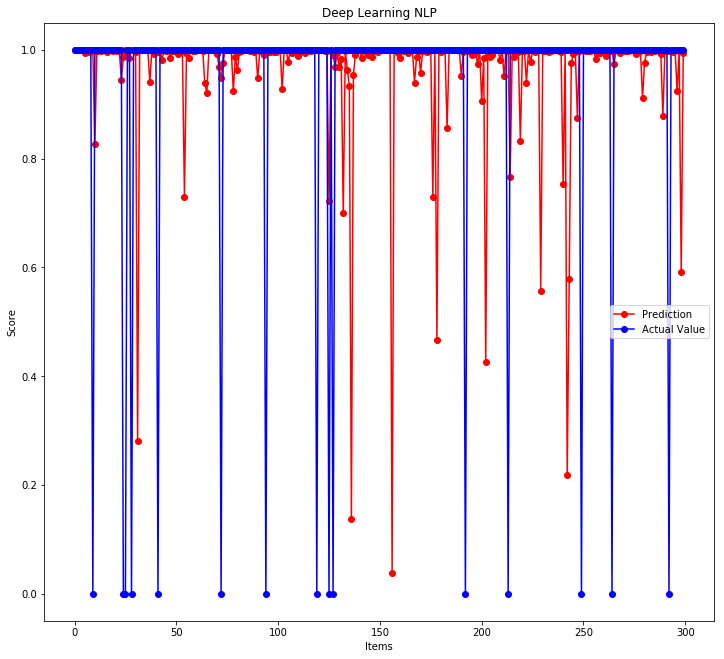

In [17]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_keras[:300], '-or', label='Prediction')
plt.plot(y_train_kera[:300], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Deep Learning NLP")

In [18]:
acc = graph_kera.history['acc']
val_acc = graph_kera.history['val_acc']
loss = graph_kera.history['loss']
val_loss = graph_kera.history['val_loss']

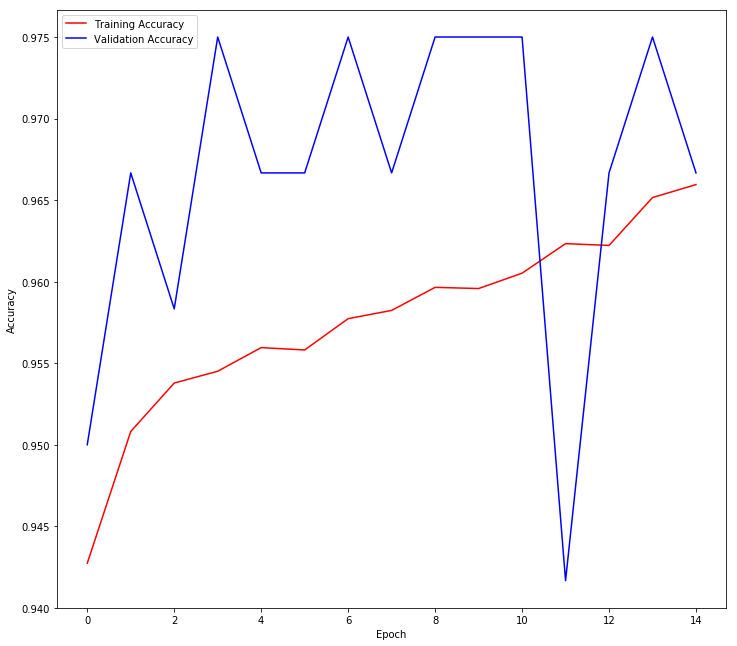

In [19]:
plt.plot(acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'b', label='Validation Accuracy')
#plt.plot(loss, 'b', label='Training loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend()


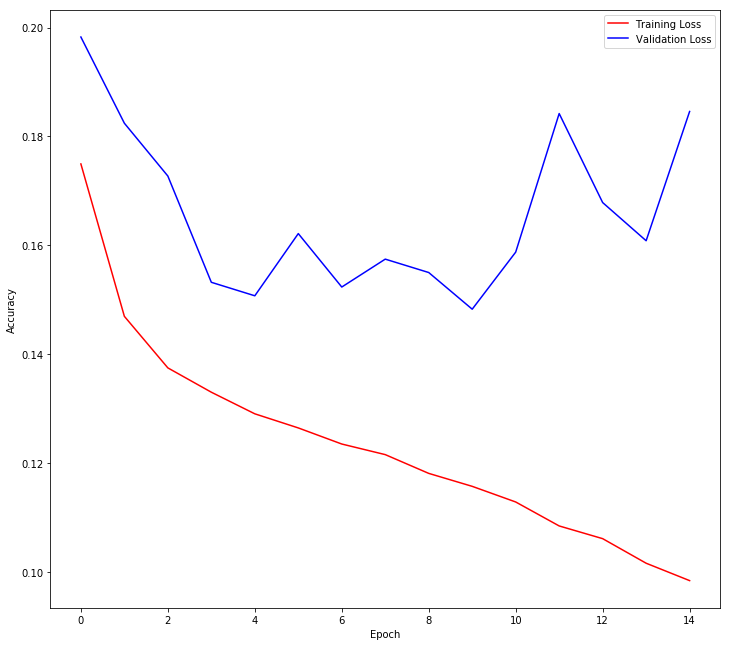

In [20]:
plt.plot(loss, 'r', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
#plt.plot(loss, 'b', label='Training loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch') 
plt.legend()



In [21]:
all_words = []
for index in range(df['newComments'].size):
    all_words.append(df['newComments'][index])


In [22]:
all_words[0]

'this product far disappoint my children love use i like abil monitor control content see eas'

In [23]:
X_process = TVec.fit_transform(all_words).toarray()

In [24]:
df['newComments'][df['newComments'] == ''].index

Int64Index([3111, 9705, 34660], dtype='int64')

In [25]:
df['newComments'].isna().any()

False

In [26]:
df['reviews.rating'].isna().any()

False

In [27]:
y_rating = df['reviews.rating'].astype(np.int64)

In [28]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_process, y_rating, test_size = 0.25, random_state = 0)

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
tree_rms = sqrt(mean_squared_error(y_pred_tree, y_test))



/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [29]:
tree_rms

0.8453590330511264

In [30]:
y_pred_tree = y_pred_tree.tolist()

In [31]:

from sklearn.metrics import f1_score
tree_f1 = f1_score(y_pred_tree, y_test, average='weighted')
print(f1_score(y_pred_tree, y_test, average='weighted'))

0.6268106202969346


In [32]:
y_test = y_test.tolist()

Current size: [12.0, 11.0]


Text(0.5,1,'Decision Tree NLP')

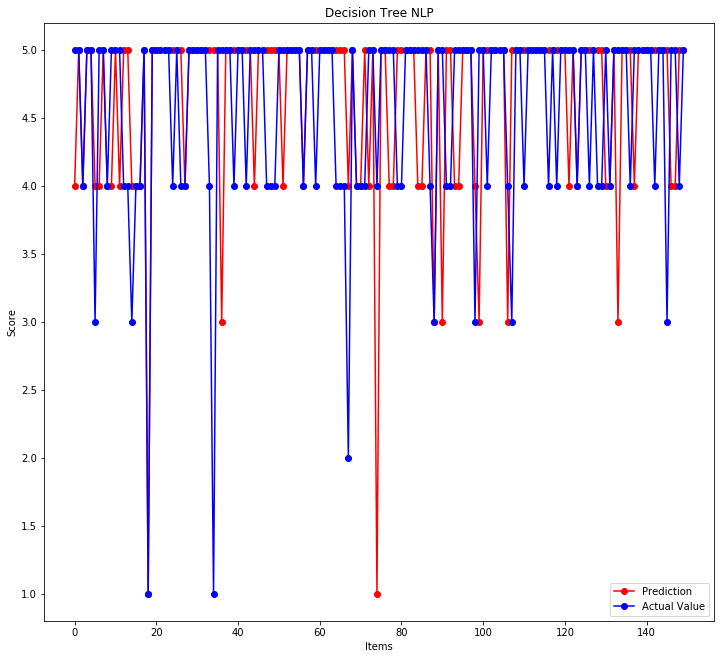

In [33]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_tree[:150], '-or', label='Prediction')
plt.plot(y_test[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Decision Tree NLP")

In [34]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB().fit(X_train, y_train)
y_pred_naive_bayes = clf.predict(X_test)

In [35]:
naive_bayesGaussianNBrms = sqrt(mean_squared_error(y_pred_naive_bayes, y_test))

In [36]:
naive_bayesGaussianNBrms


2.604873913501163

Current size: [12.0, 11.0]


Text(0.5,1,'Gaussian Naive Bayes NLP')

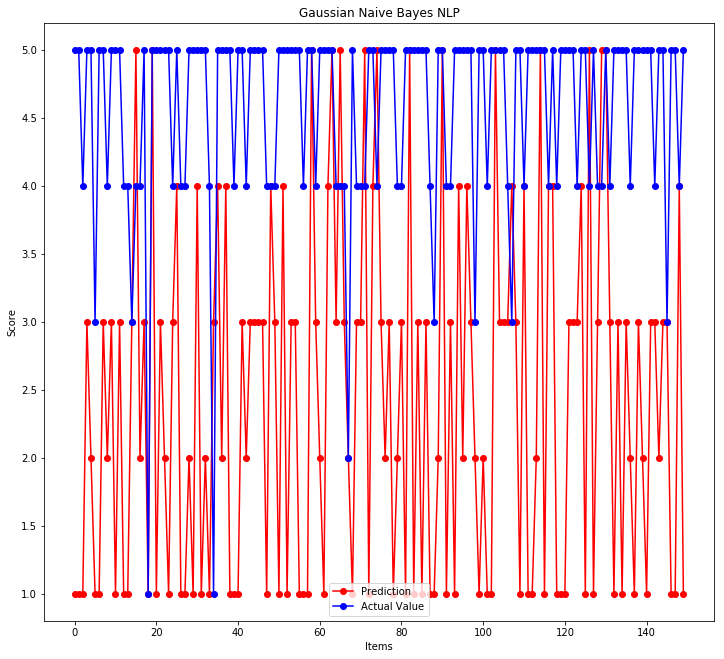

In [37]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_naive_bayes[:150], '-or', label='Prediction')
plt.plot(y_test[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Gaussian Naive Bayes NLP")

In [38]:
naive_bayesGaussianNBf1 = f1_score(y_pred_naive_bayes, y_test, average='weighted')
print(f1_score(y_pred_naive_bayes, y_test, average='weighted'))

0.07762397135740418


In [39]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)
y_pred_MultinomialNB = clf.predict(X_test)

In [40]:
naive_bayes_rms = sqrt(mean_squared_error(y_pred_MultinomialNB, y_test))
naive_bayes_rms 

0.7755941417972513

Current size: [12.0, 11.0]


Text(0.5,1,'Naive Bayes Sentiment Analysis')

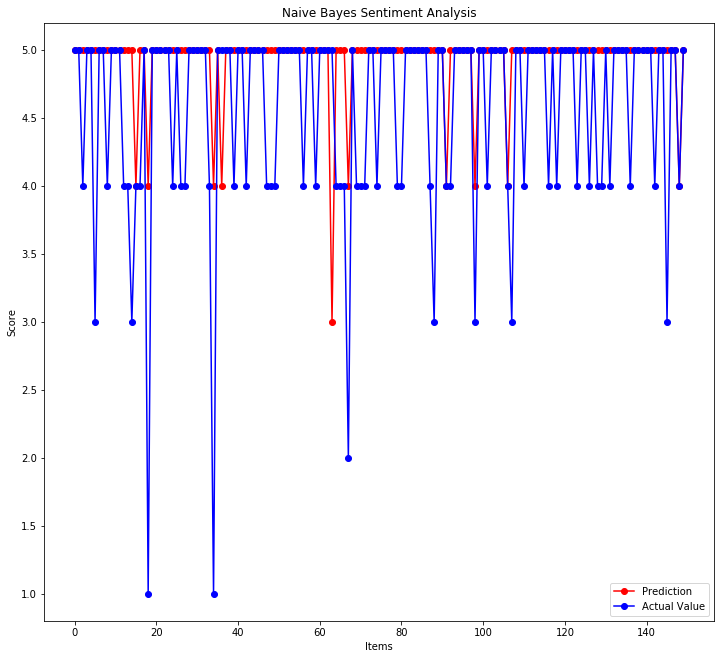

In [41]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_MultinomialNB[:150], '-or', label='Prediction')
plt.plot(y_test[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Naive Bayes Sentiment Analysis")


In [42]:
naive_bayes_f1 = f1_score(y_pred_MultinomialNB, y_test, average='weighted')
print(f1_score(y_pred_MultinomialNB, y_test, average='weighted'))

0.7902955447986636


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [43]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train, y_train)
y_pred_MLP = clf.predict(X_test)


In [44]:
MLP_rms = sqrt(mean_squared_error(y_pred_MLP, y_test))
MLP_rms 

0.6879162084881861

Current size: [12.0, 11.0]


Text(0.5,1,'Multi-layer Perceptron Sentiment Analysis')

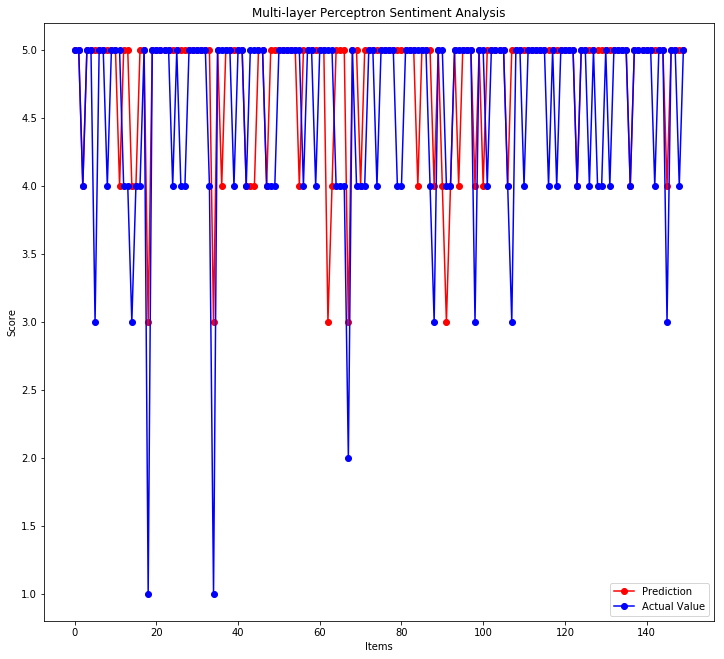

In [45]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_MLP[:150], '-or', label='Prediction')
plt.plot(y_test[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Multi-layer Perceptron Sentiment Analysis")



In [46]:
MLP_f1 = f1_score(y_pred_MLP, y_test, average='weighted')
print(f1_score(y_pred_MLP, y_test, average='weighted'))

0.7120187554128428


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


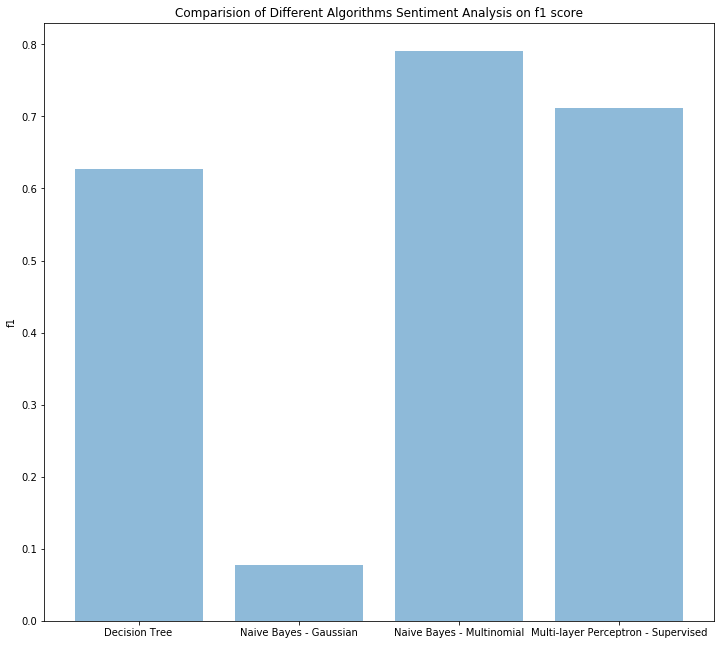

In [47]:
objects = ('Decision Tree', 'Naive Bayes - Gaussian', 'Naive Bayes - Multinomial', 'Multi-layer Perceptron - Supervised')
y_pos = np.arange(len(objects))
performance = [tree_f1, naive_bayesGaussianNBf1, naive_bayes_f1, MLP_f1]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('f1')
plt.title('Comparision of Different Algorithms Sentiment Analysis on f1 score')
 
plt.show()

In [48]:
pd.options.display.max_columns = None
display(df)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,newComments
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,,,Adapter,this product far disappoint my children love u...
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,,,truman,great beginn experienc person bought gift love
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,,,DaveZ,inexpens tablet use learn step nabi he thrill ...
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,4.000000,http://reviews.bestbuy.com/3545/5620406/review...,I've had my Fire HD 8 two weeks now and I love...,Good!!!,,,Shacks,i fire hd two week i love this tablet great va...
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,,,explore42,i bought grand daughter come visit i set user ...
5,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,5.000000,http://reviews.bestbuy.com/3545/5620406/review...,This amazon fire 8 inch tablet is the perfect ...,Just what we expected,,,tklit,this amazon fire inch tablet perfect size i pu...
6,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",,1,,0,4.000000,http://reviews.bestbuy.com/3545/5620406/review...,"Great for e-reading on the go, nice and light ...",great e-reader tablet,,,Droi,great e read go nice light weight price point ...
7,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-12T00:00:00.000Z,2017-07-0

In [49]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [50]:

def generate_word_cloud(data, color = 'black'):
    
    words = ' '.join(data)
    processed_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=3000,
                      height=2500
                     ).generate(processed_word)
    plt.figure(1,figsize=(15, 14))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


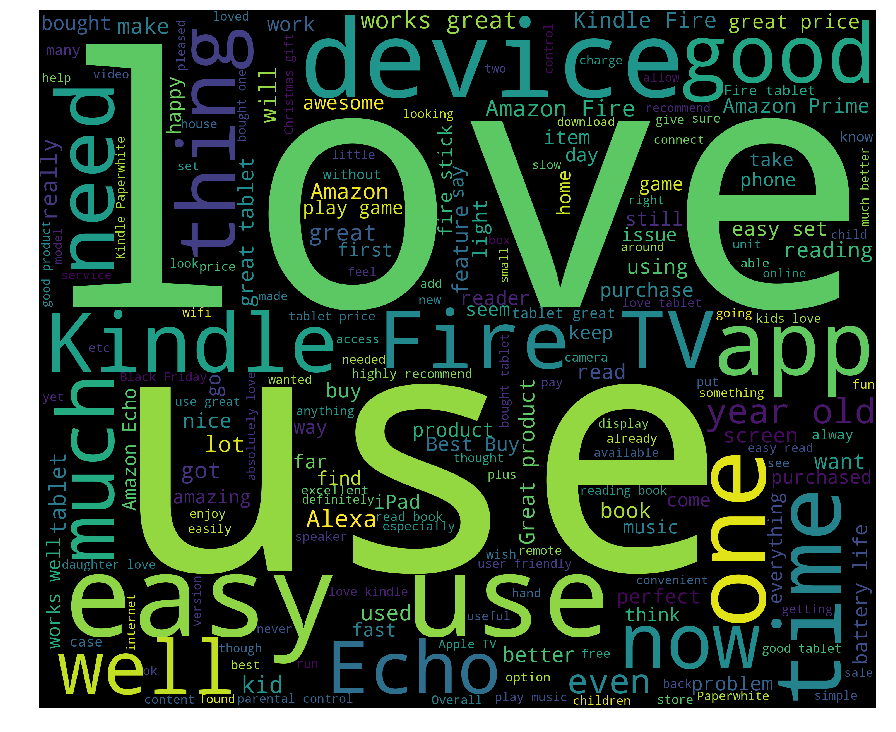

In [51]:
generate_word_cloud(df["reviews.text"],'black')


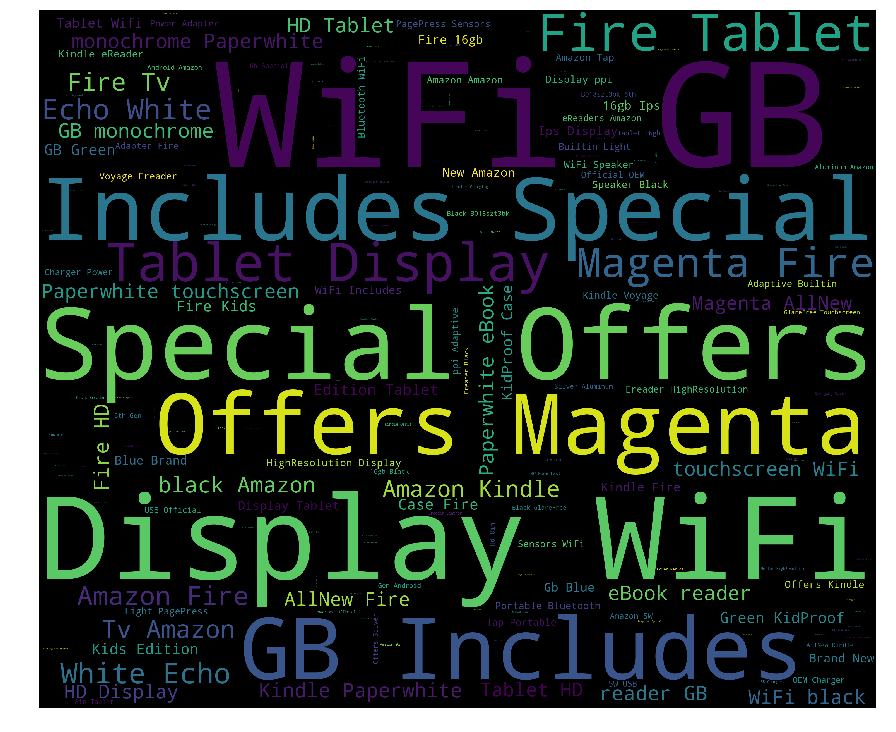

In [159]:
df['name'] = df['name'].replace(',', ' ', regex=True)
df['name'] = df['name'].replace('-', '', regex=True)
generate_word_cloud( df['name'],'black')

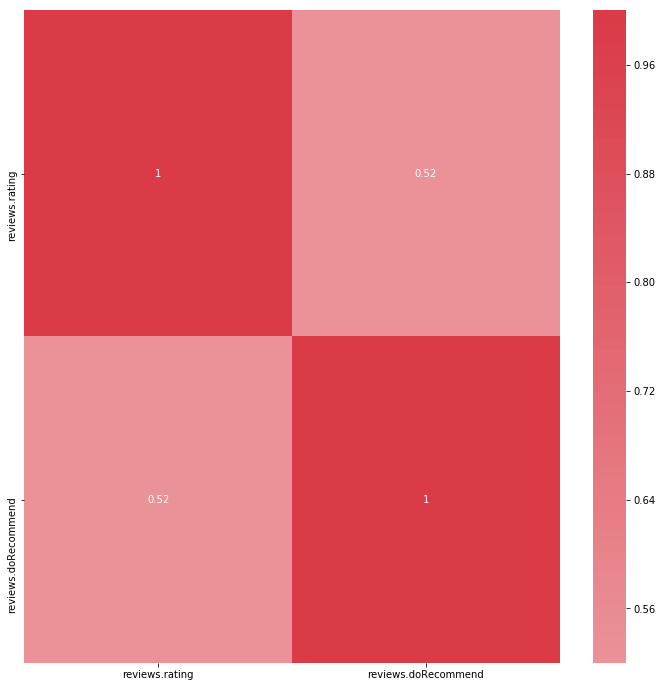

In [52]:
import seaborn as sns

numeric_features = ['reviews.rating']
ordinal_features = ['reviews.doRecommend', 'brand', 'name']
nominal_features = ['name', 'categories', 'brand']
cor_matrix = df[numeric_features + ordinal_features + nominal_features].corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(12,12));
sns.heatmap(cor_matrix, annot=True, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

In [53]:
from sklearn_pandas import CategoricalImputer
imputerCategorical = CategoricalImputer()
df.replace(' ', np.nan, inplace=True)
df['brand'] = imputerCategorical.fit_transform(df['brand'])

In [54]:
brand_type = df.groupby("brand")
brand_type.describe().head(5)

reviews.doRecommend                           \
                                           count      mean       std  min   
brand                                                                       
                                             1.0  0.000000       NaN  0.0   
Amazon                                   28701.0  0.938957  0.239414  0.0   
Amazon Coco T                                1.0  0.000000       NaN  0.0   
Amazon Digital Services Inc.                10.0  0.000000  0.000000  0.0   
Amazon Echo                                636.0  0.926101  0.261813  0.0   

                                                 reviews.rating            \
                              25%  50%  75%  max          count      mean   
brand                                                                       
                              0.0  0.0  0.0  0.0            1.0  4.584573   
Amazon                        1.0  1.0  1.0  1.0        28701.0  4.564744   
Amazon Coco T                 0.0  0.0  0.0  0.0            1.0  4.584573   
Amazon Digital Services Inc.  0.0  0.0  0.0  0.0           10.0  3.500000   
Amazon Echo                   1.0  1.0  1.0  1.0          636.0  4.531447   

                                                                      \
                                   std       min       25%       50%   
brand                                                                  
                                   NaN  4.584573  4.584573  4.584573   
Amazon                        0.746727  1.000000  4.000000  5.000000   
Amazon Coco T                      NaN  4.584573  4.584573  4.584573   
Amazon Digital Services Inc.  1.840894  1.000000  1.500000  4.500000   
Amazon Echo                   0.819421  1.000000  4.000000  5.000000   

                                                  
                                   75%       max  
brand                                             
                              4.584573  4.584573  
Amazon                        5.000000  5.000000  
Amazon Coco T                 4.584573  4.584573  
Amazon Digital Services Inc.  5.000000  5.000000  
Amazon Echo                   5.000000  5.000000

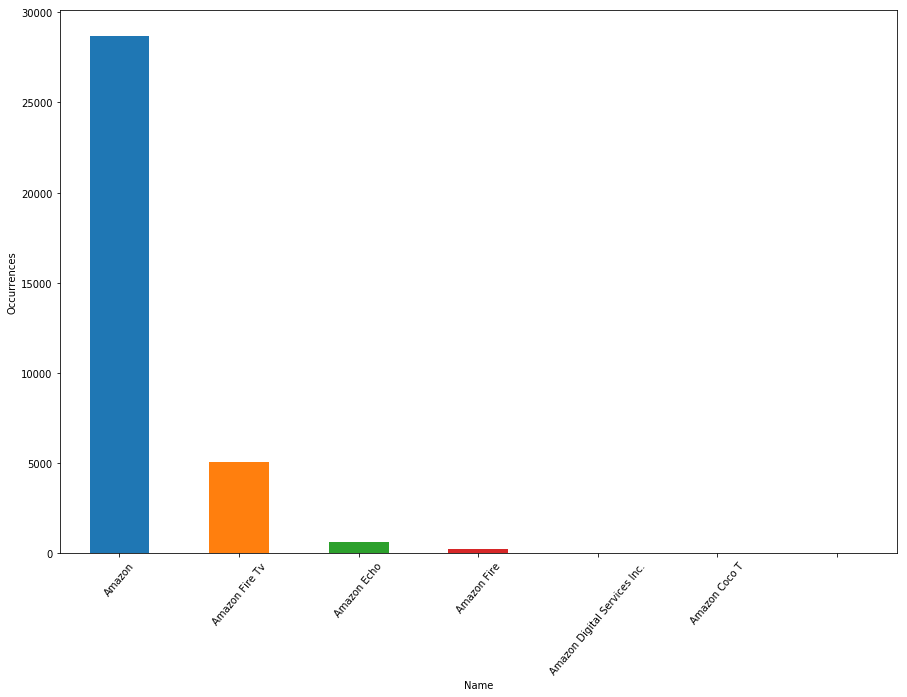

In [55]:
plt.figure(figsize=(15,10))
brand_type.size().sort_values(ascending=False).plot.bar()
#df['categories'].value_counts().head(10).plot('bar')
plt.xticks(rotation=50)
plt.xlabel("Name")
plt.ylabel("Occurrences")
plt.show()

In [56]:
df['reviews.doRecommend']

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
34631    0
34632    0
34633    0
34634    0
34635    0
34636    0
34637    0
34638    0
34639    0
34640    0
34641    0
34642    0
34643    0
34644    0
34645    0
34646    0
34647    0
34648    0
34649    0
34650    0
34651    0
34652    0
34653    0
34654    0
34655    0
34656    0
34657    0
34658    0
34659    0
34660    0
Name: reviews.doRecommend, Length: 34661, dtype: int64

In [57]:
data = spark.createDataFrame(df)

In [58]:
data = data.select('id', '`reviews.rating`', 'name', 'newComments', "`reviews.doRecommend`")
data.printSchema()
data.show(5)

root
 |-- id: string (nullable = true)
 |-- reviews.rating: double (nullable = true)
 |-- name: string (nullable = true)
 |-- newComments: string (nullable = true)
 |-- reviews.doRecommend: long (nullable = true)

+--------------------+--------------+--------------------+--------------------+-------------------+
|                  id|reviews.rating|                name|         newComments|reviews.doRecommend|
+--------------------+--------------+--------------------+--------------------+-------------------+
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|this product far ...|                  1|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|great beginn expe...|                  1|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|inexpens tablet u...|                  1|
|AVqkIhwDv8e3D1O-lebb|           4.0|All-New Fire HD 8...|i fire hd two wee...|                  1|
|AVqkIhwDv8e3D1O-lebb|           5.0|All-New Fire HD 8...|i bought grand da...|       

In [59]:
data.groupBy("`reviews.doRecommend`") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()
    

+-------------------+-----+
|reviews.doRecommend|count|
+-------------------+-----+
|                  1|32682|
|                  0| 1979|
+-------------------+-----+



In [60]:
label_encoder = LabelEncoder()

In [61]:
product_name = df['name']

In [62]:
data.groupBy("name") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()
    

+--------------------+-----+
|                name|count|
+--------------------+-----+
|Fire Tablet, 7 Di...|10966|
|                    | 6760|
|Echo (White),,,
...| 3309|
|Amazon Kindle Pap...| 3176|
|All-New Fire HD 8...| 2814|
|Amazon Fire Tv,,,...| 2527|
|Fire Kids Edition...| 1685|
|Brand New Amazon ...| 1038|
|Kindle Voyage E-r...|  580|
|Fire Tablet, 7 Di...|  372|
|Amazon - Amazon T...|  318|
|All-New Kindle E-...|  212|
|Amazon 5W USB Off...|  208|
|All-New Fire HD 8...|  158|
|Amazon Fire Hd 8 ...|  135|
|Amazon Fire Hd 10...|  128|
|Kindle Oasis E-re...|   67|
|Amazon 9W PowerFa...|   36|
|Kindle Paperwhite...|   30|
|Amazon - Kindle V...|   25|
+--------------------+-----+
only showing top 20 rows



In [63]:
from sklearn_pandas import CategoricalImputer

In [64]:
categorical_imputer = CategoricalImputer()

In [65]:
df['name'] = df['name'].replace('',np.nan, regex=True)
df['name']

0        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
1        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
2        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
3        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
4        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
5        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
6        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
7        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
8        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
9        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
10       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
11       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
12       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
13       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
14       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
15       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
16       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,.

In [66]:
df['name'] = categorical_imputer.fit_transform(df['name'])

In [67]:
df['name']

0        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
1        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
2        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
3        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
4        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
5        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
6        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
7        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
8        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
9        All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
10       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
11       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
12       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
13       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
14       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
15       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...
16       All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,.

In [68]:
integer_encoded_name = label_encoder.fit_transform(df['name'])

In [69]:
integer_encoded_name

array([ 1,  1,  1, ..., 39, 39,  0])

In [70]:
import plotly

In [71]:
print(type(data))

<class 'pyspark.sql.dataframe.DataFrame'>


In [72]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- reviews.rating: double (nullable = true)
 |-- name: string (nullable = true)
 |-- newComments: string (nullable = true)
 |-- reviews.doRecommend: long (nullable = true)



In [73]:
df['reviews.username'] = categorical_imputer.fit_transform(df['reviews.username'])

In [74]:
integer_encoded_userName = label_encoder.fit_transform(df['reviews.username'])

In [75]:
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import NormalPredictor

In [76]:
surprise_frame = pd.DataFrame(columns=['User','Item','Rating'])

In [77]:
surprise_frame['User'] = integer_encoded_userName.tolist()
surprise_frame['Item'] = integer_encoded_name.tolist()
surprise_frame['Rating'] = df['reviews.rating']

In [78]:
surprise_frame

,User,Item,Rating
0,551,1,5.000000
1,26305,1,5.000000
2,4565,1,5.000000
3,16218,1,4.000000
4,21569,1,5.000000
5,26176,1,5.000000
6,5270,1,4.000000
7,9425,1,5.000000
8,19028,1,5.000000
9,15280,1,5.000000


In [79]:
reader = Reader(line_format='user item rating',rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(surprise_frame[['User', 'Item', 'Rating']], reader)

In [80]:
surprise_data

In [81]:
cross_validate(NormalPredictor(), surprise_data, cv=2)


{'test_rmse': array([0.93379978, 0.92836979]),
 'test_mae': array([0.66322036, 0.6629382 ]),
 'fit_time': (0.01823711395263672, 0.0187070369720459),
 'test_time': (0.11883783340454102, 0.10499191284179688)}

In [82]:
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split

In [83]:
surprise_frame.to_csv("surprise_frame.csv", sep=',', encoding='utf-8', index=False)

In [84]:
reader2 = Reader(line_format='user item rating', sep = ',', rating_scale=(1, 5), skip_lines=1)


In [85]:
import os

In [86]:
file_path = os.path.expanduser('surprise_frame.csv')

In [87]:
surprise_data_2 = Dataset.load_from_file(file_path, reader=reader2)

In [88]:
surprise_data_2

In [89]:
trainset, testset = train_test_split(surprise_data_2, test_size=.25)

In [90]:
algo = SVD()

In [91]:
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)


RMSE: 0.7269


0.7268511340659228

In [92]:
algo.predict(str(550), str(0), verbose=True)

user: 550        item: 0          r_ui = None   est = 4.73   {'was_impossible': False}


Prediction(uid='550', iid='0', r_ui=None, est=4.7319807020443045, details={'was_impossible': False})

In [93]:
algo.predict(str(26304), str(0), verbose=True)

user: 26304      item: 0          r_ui = None   est = 4.80   {'was_impossible': False}


Prediction(uid='26304', iid='0', r_ui=None, est=4.804981275324145, details={'was_impossible': False})

In [94]:
algo.predict(str(4564), str(0), verbose=True)

user: 4564       item: 0          r_ui = None   est = 4.60   {'was_impossible': False}


Prediction(uid='4564', iid='0', r_ui=None, est=4.59642231844191, details={'was_impossible': False})

In [95]:
y_pred_svd = []
for item in testset:
    new_prediction = algo.predict(str(item[0]), str(item[1]), verbose=False)
    y_pred_svd.append( new_prediction[3])

user: 3826       item: 33         r_ui = None   est = 4.63   {'was_impossible': False}
user: 3012       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 8302       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 4707       item: 39         r_ui = None   est = 4.61   {'was_impossible': False}
user: 25368      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 18274      item: 39         r_ui = None   est = 4.42   {'was_impossible': False}
user: 3402       item: 33         r_ui = None   est = 4.63   {'was_impossible': False}
user: 16104      item: 22         r_ui = None   est = 4.74   {'was_impossible': False}
user: 4170       item: 33         r_ui = None   est = 4.63   {'was_impossible': False}
user: 25797      item: 46         r_ui = None   est = 4.76   {'was_impossible': False}
user: 20918      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 18319      item: 39         r_ui = No

user: 18491      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 1972       item: 22         r_ui = None   est = 4.74   {'was_impossible': False}
user: 22542      item: 38         r_ui = None   est = 4.60   {'was_impossible': False}
user: 11235      item: 25         r_ui = None   est = 4.39   {'was_impossible': False}
user: 12328      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 3942       item: 16         r_ui = None   est = 4.36   {'was_impossible': False}
user: 19950      item: 39         r_ui = None   est = 4.46   {'was_impossible': False}
user: 18342      item: 46         r_ui = None   est = 4.76   {'was_impossible': False}
user: 13414      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 2955       item: 22         r_ui = None   est = 4.74   {'was_impossible': False}
user: 17971      item: 16         r_ui = None   est = 4.60   {'was_impossible': False}
user: 21691      item: 22         r_ui = No

user: 13006      item: 37         r_ui = None   est = 4.50   {'was_impossible': False}
user: 11184      item: 22         r_ui = None   est = 4.74   {'was_impossible': False}
user: 10800      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 24930      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 17688      item: 22         r_ui = None   est = 4.74   {'was_impossible': False}
user: 10982      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 454        item: 16         r_ui = None   est = 4.48   {'was_impossible': False}
user: 13220      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 11864      item: 16         r_ui = None   est = 4.90   {'was_impossible': False}
user: 2942       item: 33         r_ui = None   est = 4.63   {'was_impossible': False}
user: 15292      item: 39         r_ui = None   est = 4.57   {'was_impossible': False}
user: 1330       item: 25         r_ui = No

user: 15107      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 15525      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 5543       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 3425       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 21950      item: 16         r_ui = None   est = 4.60   {'was_impossible': False}
user: 14232      item: 16         r_ui = None   est = 4.60   {'was_impossible': False}
user: 1914       item: 16         r_ui = None   est = 4.75   {'was_impossible': False}
user: 22773      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 7235       item: 39         r_ui = None   est = 4.68   {'was_impossible': False}
user: 3651       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 14948      item: 6          r_ui = None   est = 4.62   {'was_impossible': False}
user: 12399      item: 22         r_ui = No

user: 707        item: 39         r_ui = None   est = 4.42   {'was_impossible': False}
user: 20558      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 22823      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 23719      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 17190      item: 46         r_ui = None   est = 4.44   {'was_impossible': False}
user: 16190      item: 33         r_ui = None   est = 4.63   {'was_impossible': False}
user: 15103      item: 1          r_ui = None   est = 4.73   {'was_impossible': False}
user: 11674      item: 39         r_ui = None   est = 4.49   {'was_impossible': False}
user: 4608       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 14353      item: 22         r_ui = None   est = 4.74   {'was_impossible': False}
user: 13785      item: 22         r_ui = None   est = 4.74   {'was_impossible': False}
user: 21616      item: 39         r_ui = No

user: 20593      item: 16         r_ui = None   est = 4.60   {'was_impossible': False}
user: 21904      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 2567       item: 39         r_ui = None   est = 4.37   {'was_impossible': False}
user: 1243       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 13575      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 708        item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 7900       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 19719      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 18100      item: 25         r_ui = None   est = 4.53   {'was_impossible': False}
user: 5074       item: 22         r_ui = None   est = 4.74   {'was_impossible': False}
user: 17292      item: 33         r_ui = None   est = 4.63   {'was_impossible': False}
user: 11413      item: 25         r_ui = No

user: 1780       item: 9          r_ui = None   est = 4.80   {'was_impossible': False}
user: 3846       item: 46         r_ui = None   est = 4.86   {'was_impossible': False}
user: 21570      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 10925      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 12362      item: 22         r_ui = None   est = 4.74   {'was_impossible': False}
user: 16721      item: 16         r_ui = None   est = 4.50   {'was_impossible': False}
user: 6477       item: 33         r_ui = None   est = 4.63   {'was_impossible': False}
user: 22390      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 8187       item: 3          r_ui = None   est = 4.38   {'was_impossible': False}
user: 22912      item: 22         r_ui = None   est = 4.74   {'was_impossible': False}
user: 18196      item: 16         r_ui = None   est = 4.49   {'was_impossible': False}
user: 24983      item: 22         r_ui = No

user: 12413      item: 1          r_ui = None   est = 4.57   {'was_impossible': False}
user: 4865       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 2175       item: 46         r_ui = None   est = 4.76   {'was_impossible': False}
user: 19507      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 7897       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 8545       item: 39         r_ui = None   est = 4.59   {'was_impossible': False}
user: 19092      item: 37         r_ui = None   est = 4.50   {'was_impossible': False}
user: 12458      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 21452      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 1546       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 16081      item: 39         r_ui = None   est = 4.66   {'was_impossible': False}
user: 22664      item: 39         r_ui = No

user: 19144      item: 38         r_ui = None   est = 4.90   {'was_impossible': False}
user: 16577      item: 33         r_ui = None   est = 4.63   {'was_impossible': False}
user: 5123       item: 39         r_ui = None   est = 4.57   {'was_impossible': False}
user: 2248       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 11285      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 25883      item: 4          r_ui = None   est = 4.75   {'was_impossible': False}
user: 16047      item: 1          r_ui = None   est = 4.59   {'was_impossible': False}
user: 20935      item: 22         r_ui = None   est = 4.74   {'was_impossible': False}
user: 17318      item: 16         r_ui = None   est = 4.60   {'was_impossible': False}
user: 14452      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 3329       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 11595      item: 39         r_ui = No

user: 26373      item: 22         r_ui = None   est = 4.74   {'was_impossible': False}
user: 18330      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 16733      item: 1          r_ui = None   est = 4.59   {'was_impossible': False}
user: 4243       item: 25         r_ui = None   est = 4.39   {'was_impossible': False}
user: 1268       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 12022      item: 22         r_ui = None   est = 4.71   {'was_impossible': False}
user: 1314       item: 33         r_ui = None   est = 4.76   {'was_impossible': False}
user: 24691      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 9641       item: 33         r_ui = None   est = 4.68   {'was_impossible': False}
user: 16993      item: 33         r_ui = None   est = 4.49   {'was_impossible': False}
user: 9407       item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 16132      item: 39         r_ui = No

user: 8536       item: 33         r_ui = None   est = 4.64   {'was_impossible': False}
user: 20222      item: 25         r_ui = None   est = 4.53   {'was_impossible': False}
user: 5312       item: 16         r_ui = None   est = 4.60   {'was_impossible': False}
user: 316        item: 16         r_ui = None   est = 4.60   {'was_impossible': False}
user: 25777      item: 1          r_ui = None   est = 4.79   {'was_impossible': False}
user: 3086       item: 39         r_ui = None   est = 4.49   {'was_impossible': False}
user: 18965      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 24891      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 24371      item: 39         r_ui = None   est = 4.53   {'was_impossible': False}
user: 18248      item: 16         r_ui = None   est = 4.46   {'was_impossible': False}
user: 18765      item: 37         r_ui = None   est = 4.64   {'was_impossible': False}
user: 14366      item: 39         r_ui = No

In [96]:
y_test_svd = []
for item in testset:
    y_test_svd.append(item[2])
    

Current size: [12.0, 11.0]


Text(0.5,1,'SVD method from Surprise Library Prediction')

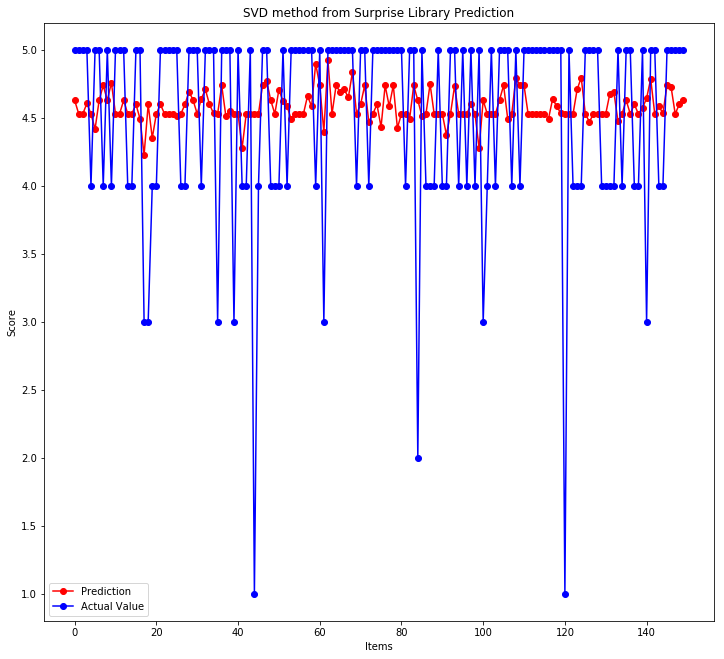

In [97]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_svd[:150], '-or', label='Prediction')
plt.plot(y_test_svd[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("SVD method from Surprise Library Prediction")

In [145]:
from sklearn.metrics import mean_squared_error
svd_rms = mean_squared_error(y_pred_svd, y_test_svd)

In [146]:
svd_rms

0.5283125710929182

In [99]:
df = df.replace('', np.nan, regex=True)

In [100]:
df['name'].isna().any()

False

In [101]:
df[df['name'] == ''].index

Int64Index([], dtype='int64')

In [102]:
df['brand'].isna().any()

True

In [103]:
df[df['brand'] == ''].index

Int64Index([], dtype='int64')

In [104]:
from sklearn_pandas import CategoricalImputer
imputerCategorical = CategoricalImputer()

In [105]:
df['brand'] = imputerCategorical.fit_transform(df['brand'])

In [106]:
df['brand'].isna().any()

False

In [107]:
df['categories'].isna().any()

True

In [108]:
df['categories'] = imputerCategorical.fit_transform(df['categories'])

In [109]:
df['categories'].isna().any()

False

In [110]:
df['manufacturer'].isna().any()

True

In [111]:
df['manufacturer'] = imputerCategorical.fit_transform(df['manufacturer'])

In [112]:
df['manufacturer'].isna().any()

False

In [113]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()

In [114]:
frames = [df['name'], df['brand'], df['categories'], df['manufacturer']]

In [115]:
df_new = pd.concat(frames, axis=1)

In [116]:
X = df_new.iloc[:, :].values

In [117]:
X

array([['All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta',
        'Amazon',
        'Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets',
        'Amazon'],
       ['All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta',
        'Amazon',
        'Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets',
        'Amazon'],
       ['All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta',
        'Amazon',
        'Electronics,iPad & Tablets,All Tablets,Fire Tablets,Tablets,Computers & Tablets',
        'Amazon'],
       ...,
       ['Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta',
        'Amazon',
        'Computers/Tablets & Networking,Tablet & eBook Reader Accs,Chargers & Sync Cables,Power Adapters & Cables,Kindle Store,Amazon Device Accessories,Fire Tablet Accessories,Kindle Fire (2nd Generation) A

In [118]:
for i in range(X.shape[1]):
    X[:, i] =  labelencoder.fit_transform(X[:, i]) 




In [119]:
X

array([[1, 0, 21, 0],
       [1, 0, 21, 0],
       [1, 0, 21, 0],
       ...,
       [39, 0, 8, 1],
       [39, 0, 8, 1],
       [0, 0, 25, 0]], dtype=object)

In [120]:
y = df['reviews.rating']

In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

In [122]:
from sklearn.ensemble import RandomForestRegressor

In [123]:
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)

In [124]:
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [147]:
y_pred_random_forest = regr.predict(X_test).tolist()

In [149]:
y_test2 = []
for item in y_test:
    y_test2.append(item)
y_test = y_test2

Current size: [12.0, 11.0]


Text(0.5,1,'Random Forest Regressor')

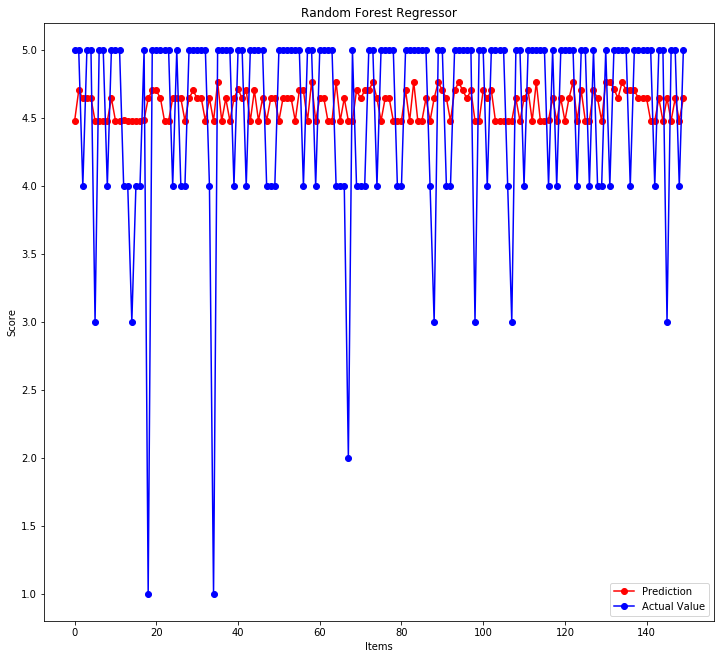

In [150]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred[:150], '-or', label='Prediction')
plt.plot(y_test[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("Random Forest Regressor")

In [151]:

random_forest_rms = mean_squared_error(y_pred_random_forest, y_test)

In [152]:
random_forest_rms

0.5156770885259061

In [129]:
from sklearn.neighbors import KNeighborsClassifier

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train.astype('int')) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [138]:
y_pred_k_nearest = neigh.predict(X_test)

In [139]:
y_pred_k_nearest

array([5, 5, 5, ..., 5, 5, 5])

Current size: [12.0, 11.0]


Text(0.5,1,'K Nearest Neighbor')

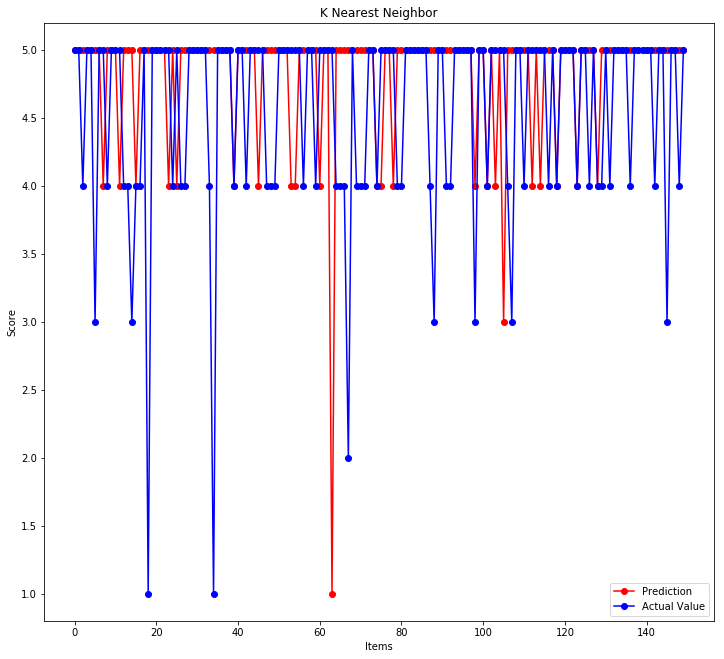

In [143]:
score_plot = plt.rcParams["figure.figsize"]
 
print("Current size:", score_plot)
 
score_plot[0] = 12
score_plot[1] = 11
plt.rcParams["figure.figsize"] = score_plot

plt.plot(y_pred_k_nearest[:150], '-or', label='Prediction')
plt.plot(y_test2[:150], '-ob', label='Actual Value')
plt.ylabel('Score')
plt.xlabel('Items') 
plt.legend()
plt.title("K Nearest Neighbor")

In [154]:
k_nearest_rms = mean_squared_error(y_pred_k_nearest, y_test)

In [155]:
k_nearest_rms

0.7788193061768416

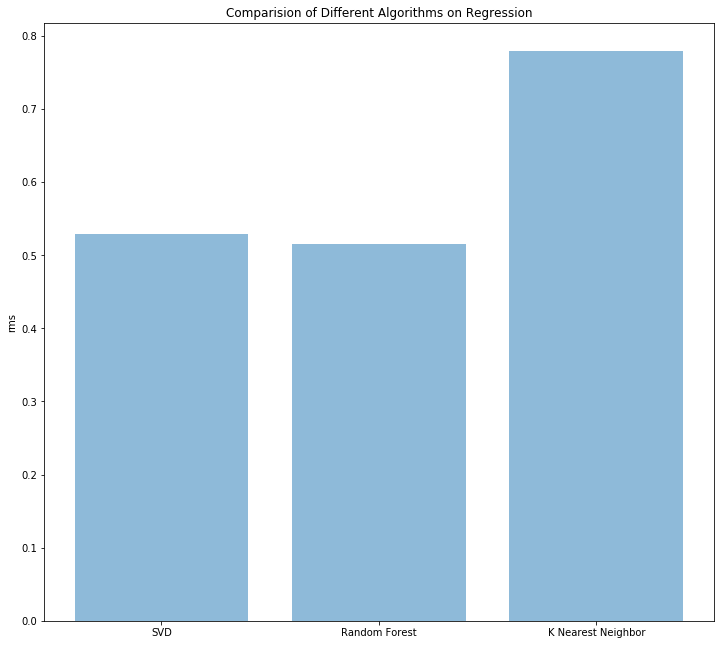

In [160]:
objects = ('SVD', 'Random Forest', 'K Nearest Neighbor')
y_pos = np.arange(len(objects))
performance = [svd_rms, random_forest_rms,  k_nearest_rms]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('rms')
plt.title('Comparision of Different Algorithms on Regression')
 
plt.show()